#### TODO

- [ ] Generate the random dispersing centers
- [ ] Define the free space Green's function
- [ ] Create the M matrix
- [ ] solve the linear system

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.special import hankel1
from scipy.constants import pi, hbar

Defining the energy as:

$$E'=\frac{\hbar^2k^2}{2m}$$

We can extract $k$ as:

$$k=\sqrt{\frac{2mE'}{\hbar^2}}$$

But, energy is given in units of $E_0=\frac{\hbar^2}{md^2}$, such that $E=E'/E_0$, so we can write:

$$k=\sqrt{\frac{2mE'}{\hbar^2}}=\sqrt{\frac{2mE_0E}{\hbar^2}}=\sqrt{\frac{2E}{d^2}}$$

In [2]:
def generate_circular_lattice(n):
    x = np.linspace(-1, 1, n)
    y = np.linspace(-1, 1, n)
    X, Y = np.meshgrid(x, y)

    # mask out the points outside the circle
    R = np.sqrt(X**2 + Y**2)
    mask = R <= 1

    # generate a mesh of points in the circle
    X = X[mask]
    Y = Y[mask]
    return X, Y

In [3]:
def generate_circular_lattice(radius=2, spacing=0.01, n=None):
    if n is None:
        n = int(radius/spacing)
    
    x = np.linspace(-radius, radius, n)
    y = np.linspace(-radius, radius, n)
    X, Y = np.meshgrid(x, y)

    # mask out the points outside the circle
    R = np.sqrt(X**2 + Y**2)
    mask = R <= radius

    # generate a mesh of points in the circle
    X = X[mask]
    Y = Y[mask]
    return X, Y

Careful with the units, as the energy is given in units of $E_0$, the wavevector is given in units of $1/d$.

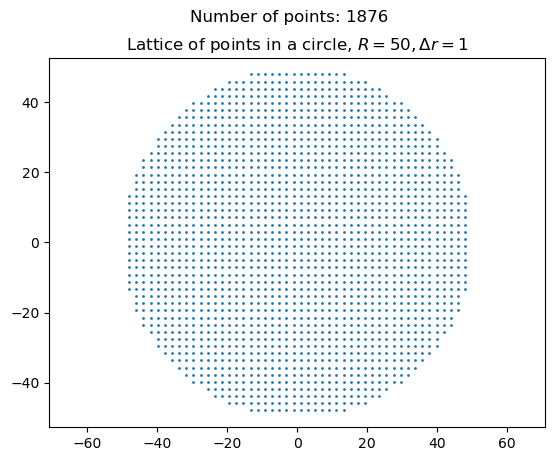

In [4]:
R=50
spacing=1

X,Y=generate_circular_lattice(radius=R, spacing=spacing)

plt.scatter(X, Y, s=1)
plt.title(f'Lattice of points in a circle, $R={R}, \Delta r={spacing}$')
plt.suptitle(f'Number of points: {len(X)}')

plt.axis('equal');

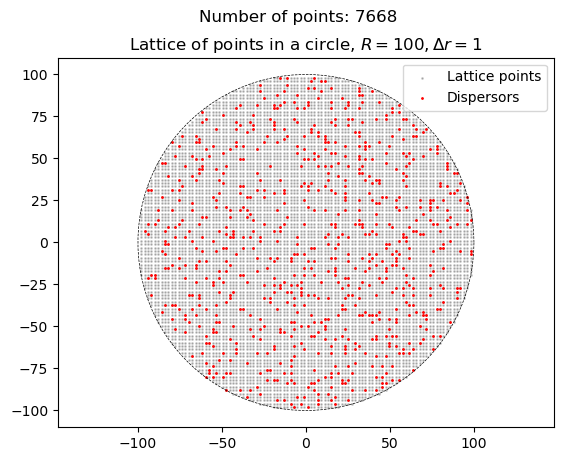

In [5]:
R=100
# spacing=0.04

X,Y=generate_circular_lattice(radius=R, spacing=spacing)

# choose each point with probability p
p=.1
np.random.seed(42) # !!!for reproducibility
mask = np.random.rand(len(X)) < p
X_dispersors=X[mask]
Y_dispersors=Y[mask]

plt.scatter(X, Y, s=1, label='Lattice points', color=(0,0,0,0.2))
plt.scatter(X_dispersors, Y_dispersors, s=1, label='Dispersors', c='r')
plt.title(f'Lattice of points in a circle, $R={R}, \Delta r={spacing}$')
plt.suptitle(f'Number of points: {len(X)}')
# plot a circle of radius R
t = np.linspace(0, 2*pi, 100)
plt.plot(R*np.cos(t), R*np.sin(t), 'k--', linewidth=0.5)
plt.legend()
plt.axis('equal');


This verifies the continuum limit which is that the area of a circle is given by $A=\pi (l/2)^2$, and the area of a square is given by $A=l^2$, so:

$$\frac{A_{circle}}{A_{square}}=\frac{\pi (l/2)^2}{l^2}=\frac{\pi}{4}\sim 0.785398...\to A_{circle}=\frac{\pi}{4}A_{square}\approx_{N\to \infty} N_{circle}=\frac{\pi}{4}N_{square}$$

# Linear system of equations

The linear system of equations is given by:

$$\sum_{j=1}^{N}M_{ij}D_j=\frac{i\pi}{2}H_0^{(1)}(k(r_i-r_0))$$

Where $M_{ij}$ is given by:

$$M_{ij}=\left \{\begin{matrix}-\frac{i\pi}{2}H_0^{(1)}(k(r_i-r_j))& i\neq j\\\ln{\left(\frac{ka_{eff}e^\gamma}{2}\right)}-\frac{i\pi}{2} & i=j\end{matrix}\right.$$

In [57]:
m_matrix = np.zeros((len(X_dispersors), len(Y_dispersors)), dtype=np.complex128)
energy = 1
d=1
a_eff = 2.2
k=np.sqrt(2*energy)/d

gamma_euler = 0.57721566490153286060

for i, (x, y) in enumerate(zip(X_dispersors, Y_dispersors)):
    for j, (x_prime, y_prime) in enumerate(zip(X_dispersors, Y_dispersors)):
        if i == j:
            m_matrix[i, j] = np.log(k*a_eff*np.exp(gamma_euler))-1j*np.pi/2
        else:
            m_matrix[i, j] = -1j*np.pi/4*hankel1(0, k*np.sqrt((x-x_prime)**2+(y-y_prime)**2))
            
# plt.imshow(np.abs(m_matrix), cmap='viridis')

In [76]:
def generate_diag_off_diag_matrices(k, a_eff, X_dispersors, Y_dispersors):
    diagonal_terms = np.zeros((len(X_dispersors), len(Y_dispersors)), dtype=np.complex128)
    off_diagonal_terms = np.zeros((len(X_dispersors), len(Y_dispersors)), dtype=np.complex128)

    for i, (x, y) in enumerate(zip(X_dispersors, Y_dispersors)):
        for j, (x_prime, y_prime) in enumerate(zip(X_dispersors, Y_dispersors)):
            if i == j:
                diagonal_terms[i, j] = np.log(k*a_eff*np.exp(gamma_euler))-1j*np.pi/2
            else:
                off_diagonal_terms[i, j] = -1j*np.pi/2*hankel1(0, k*np.sqrt((x-x_prime)**2+(y-y_prime)**2))
    return diagonal_terms, off_diagonal_terms

diagonal_terms = np.zeros((len(X_dispersors), len(Y_dispersors)), dtype=np.complex128)
off_diagonal_terms = np.zeros((len(X_dispersors), len(Y_dispersors)), dtype=np.complex128)

for i, (x, y) in enumerate(zip(X_dispersors, Y_dispersors)):
    for j, (x_prime, y_prime) in enumerate(zip(X_dispersors, Y_dispersors)):
        if i == j:
            diagonal_terms[i, j] = np.log(k*a_eff*np.exp(gamma_euler))-1j*np.pi/2
        else:
            off_diagonal_terms[i, j] = -1j*np.pi/4*hankel1(0, k*np.sqrt((x-x_prime)**2+(y-y_prime)**2))

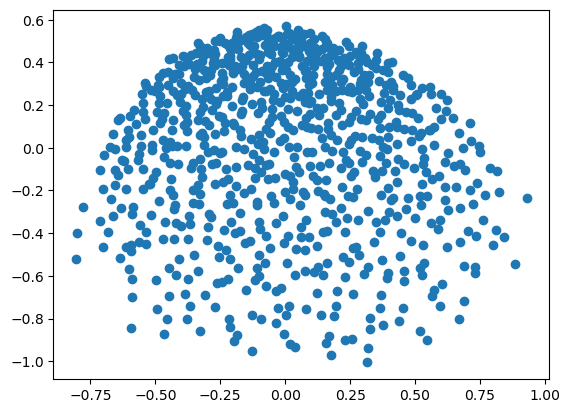

In [77]:
off_diagonal_eigvals, off_diagonal_eigvecs = np.linalg.eig(off_diagonal_terms)

plt.plot(np.real(off_diagonal_eigvals), np.imag(off_diagonal_eigvals), 'o')

[]

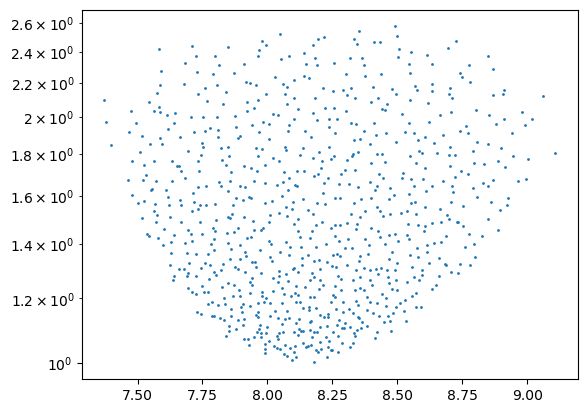

In [78]:
new_eigvals = np.log(a_eff*k*np.exp(gamma_euler))-1j*np.pi/2+off_diagonal_eigvals
plt.plot(np.real(new_eigvals), np.abs(np.imag(new_eigvals)), 'o',markersize=1)
plt.semilogy()

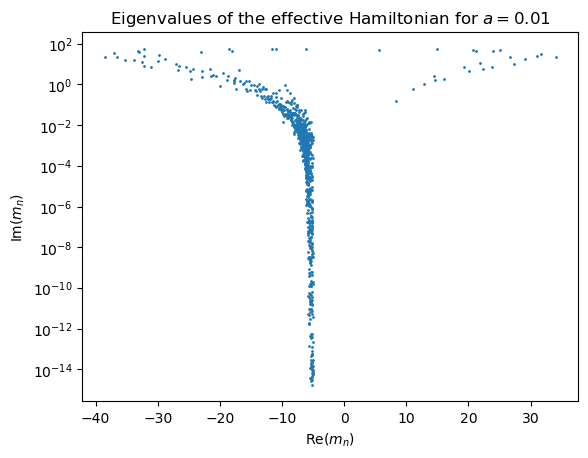

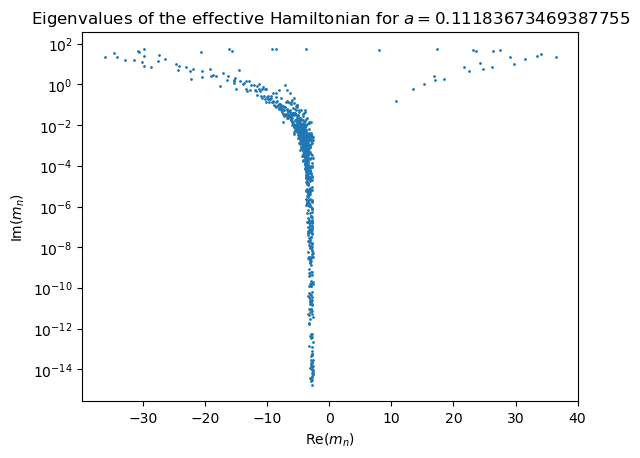

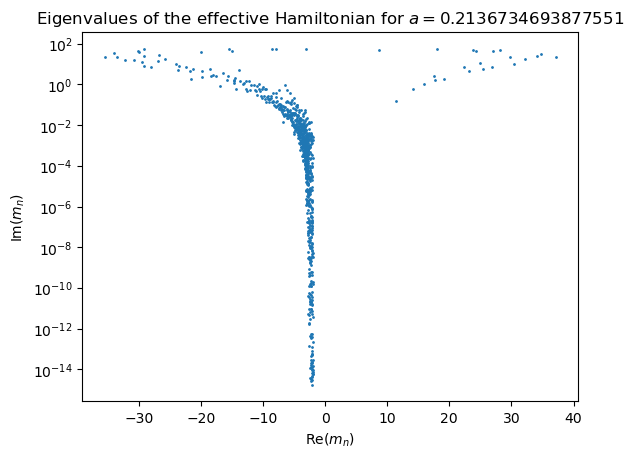

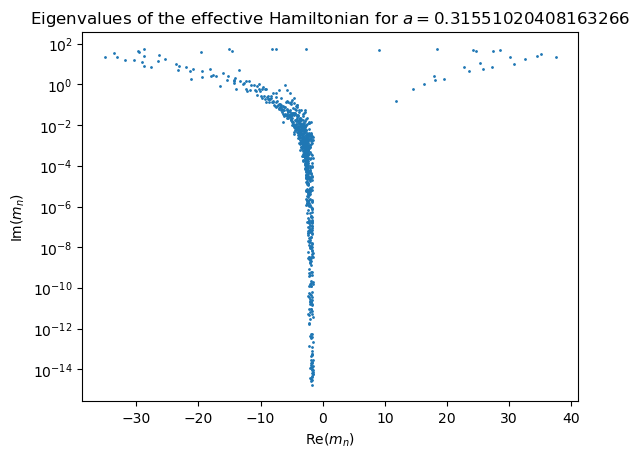

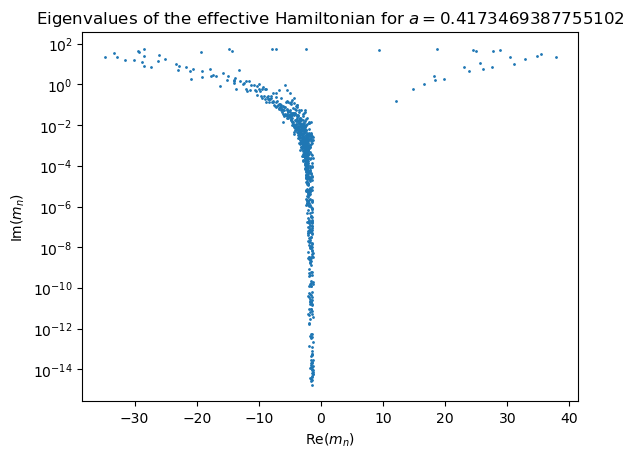

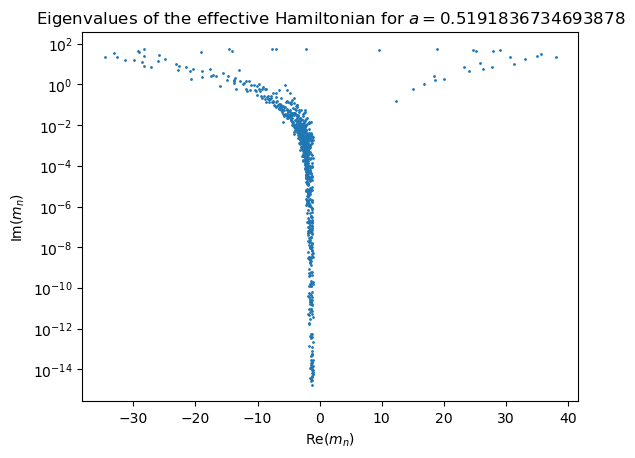

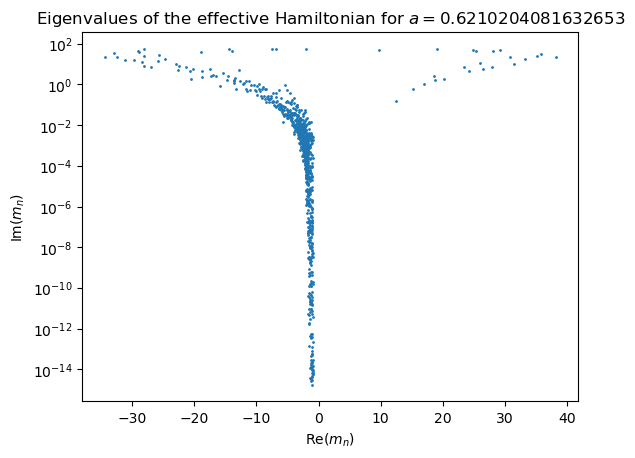

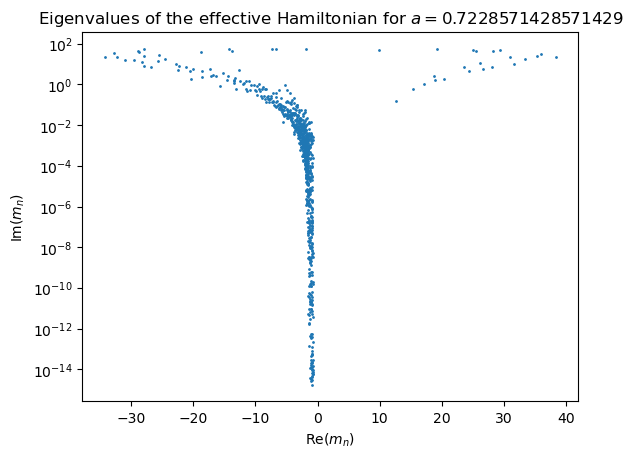

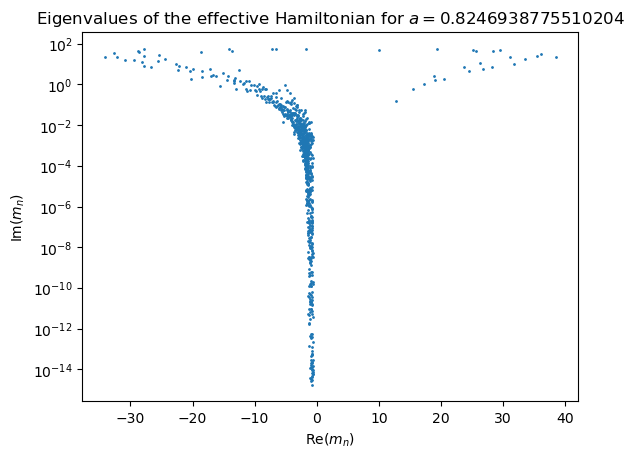

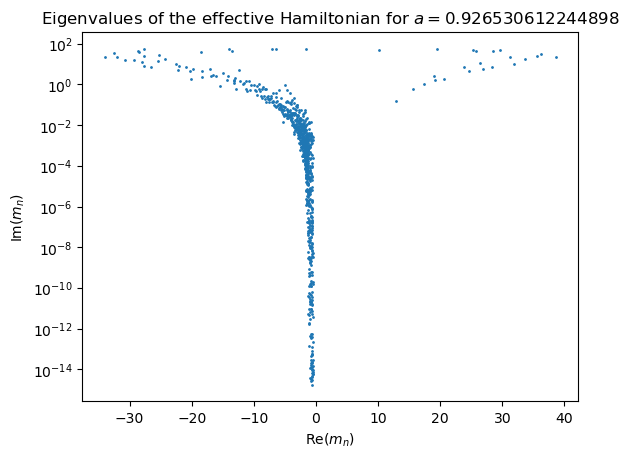

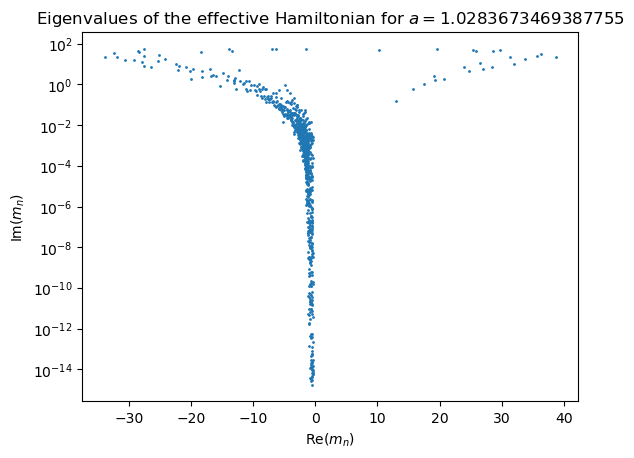

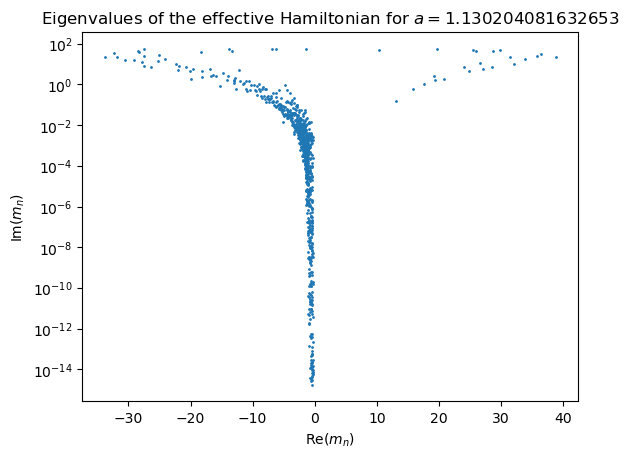

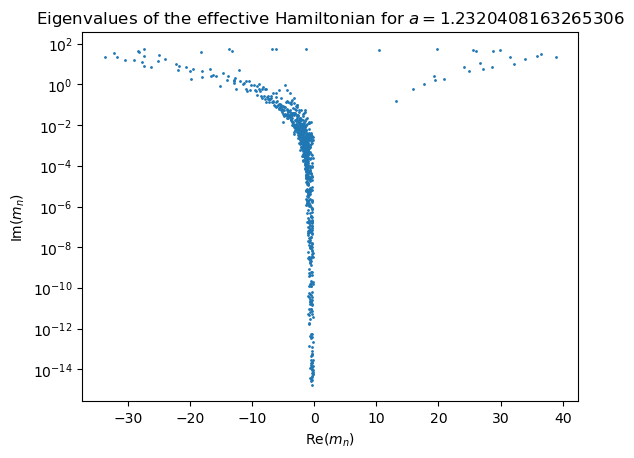

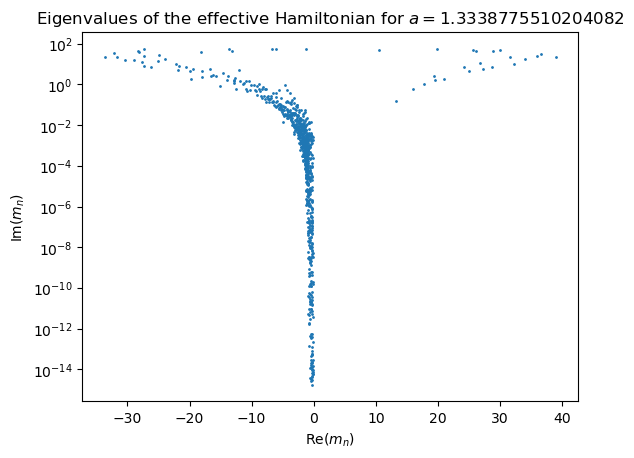

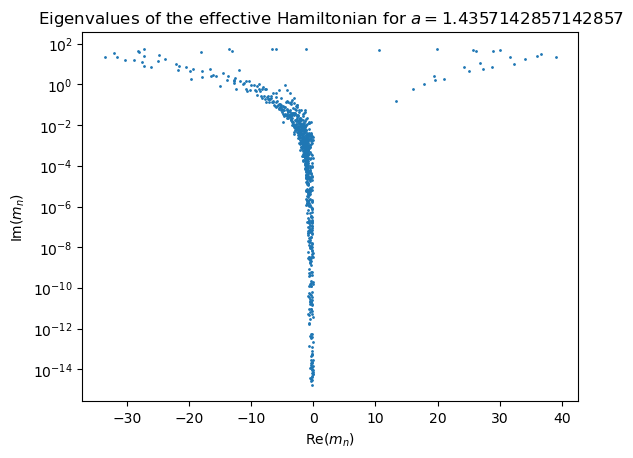

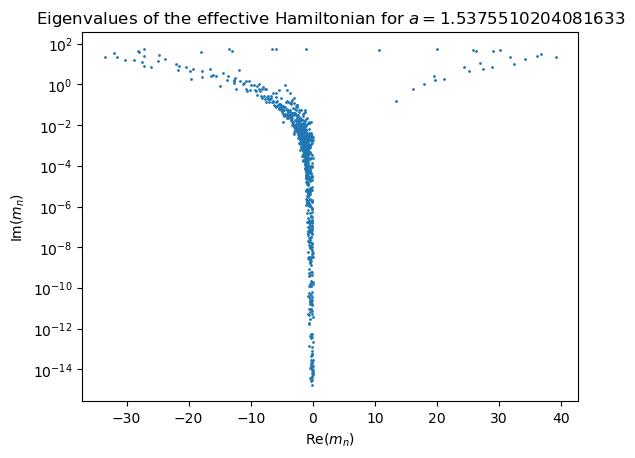

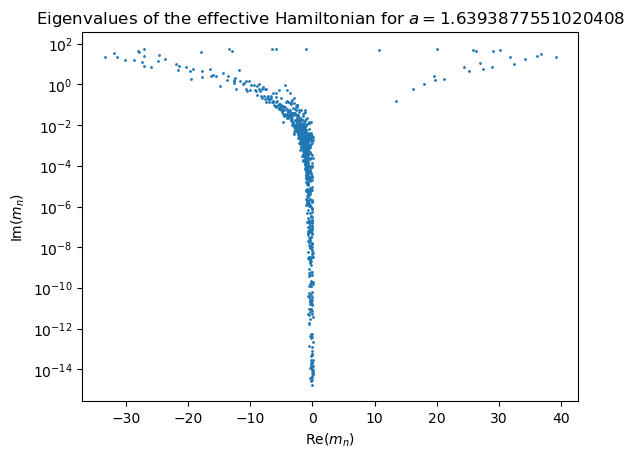

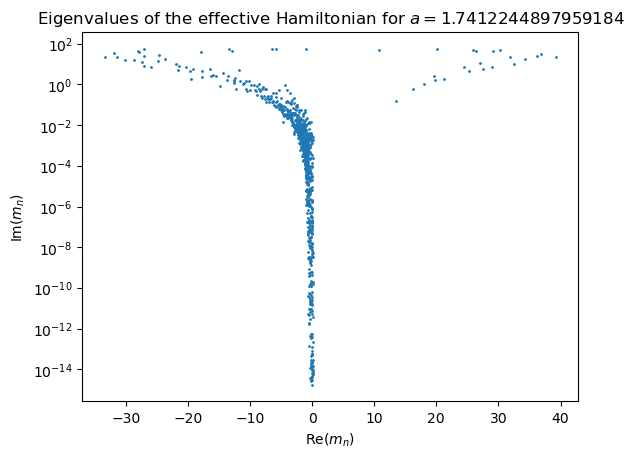

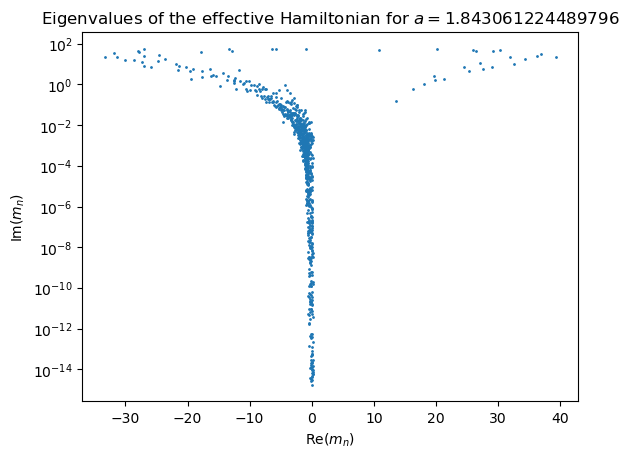

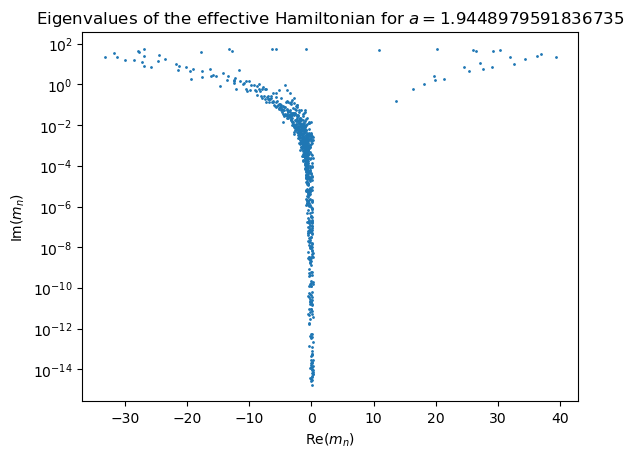

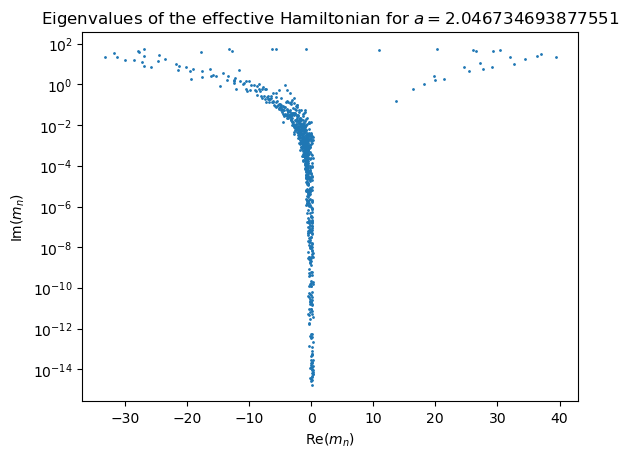

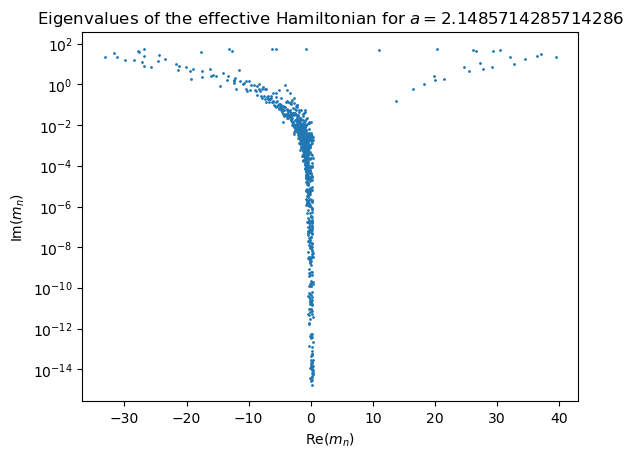

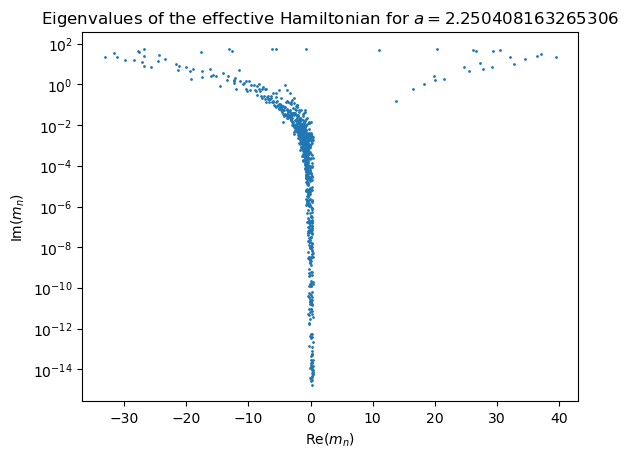

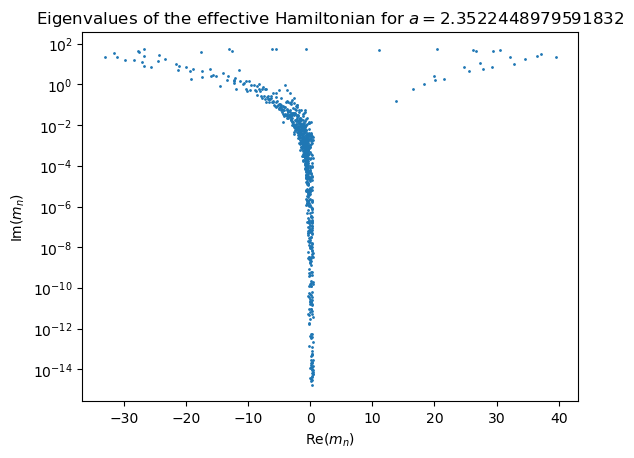

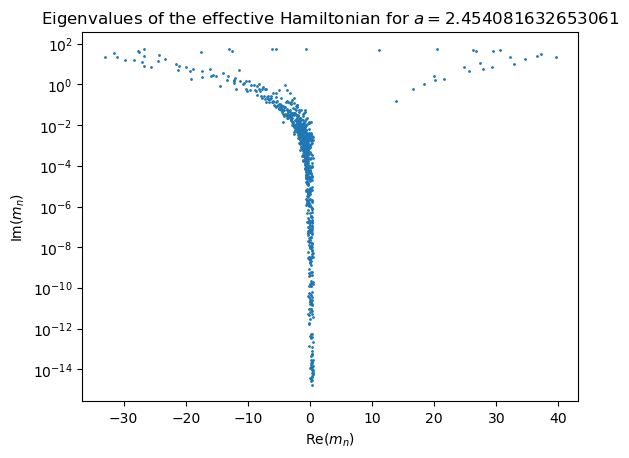

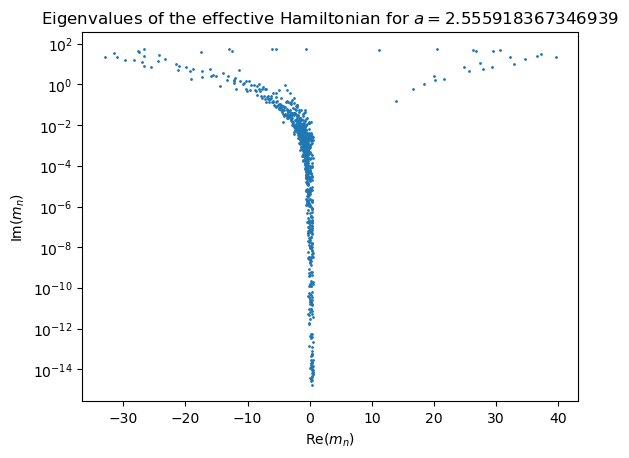

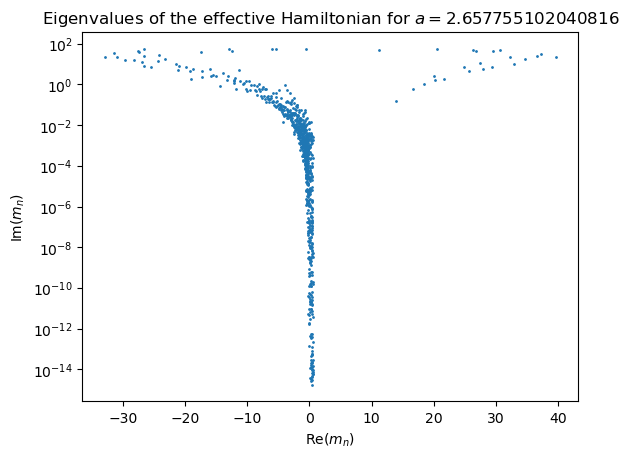

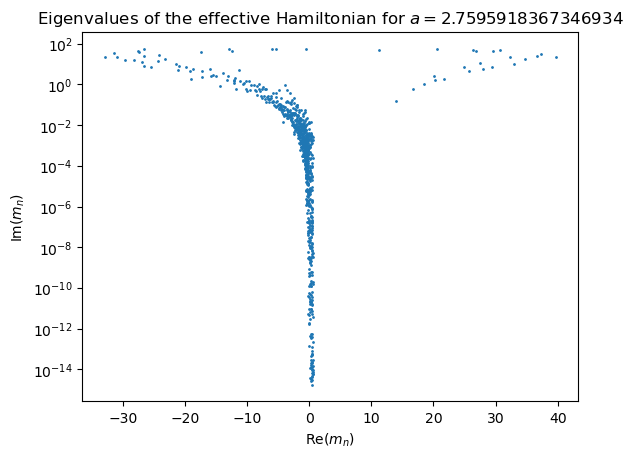

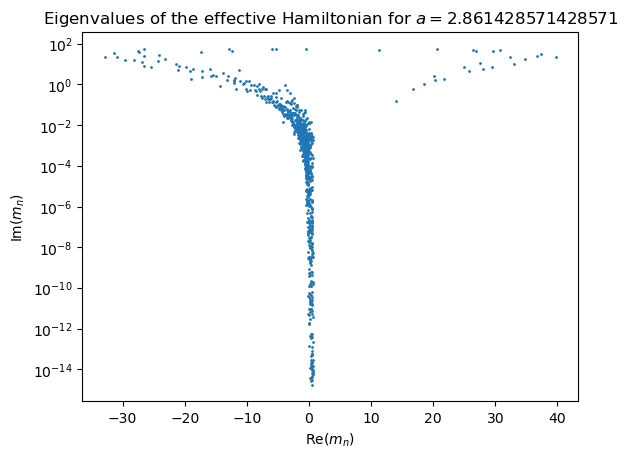

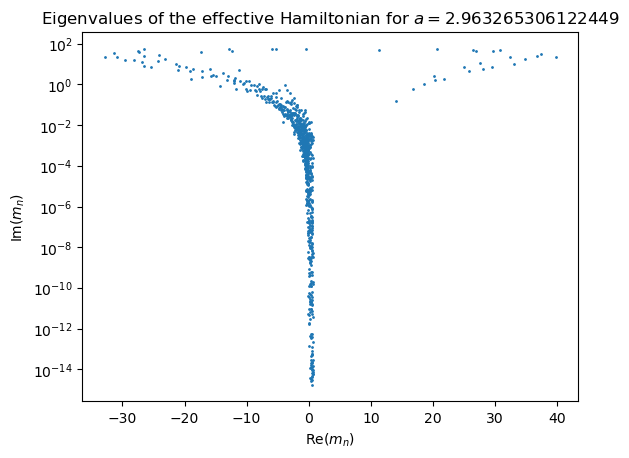

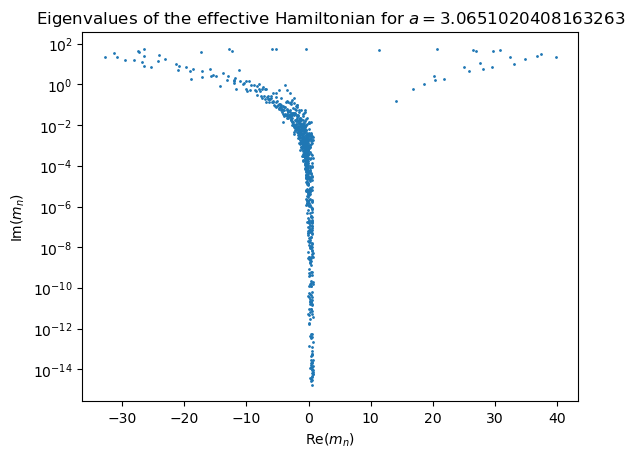

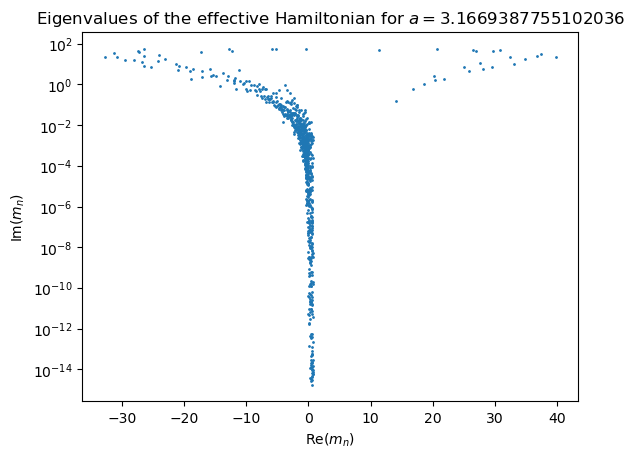

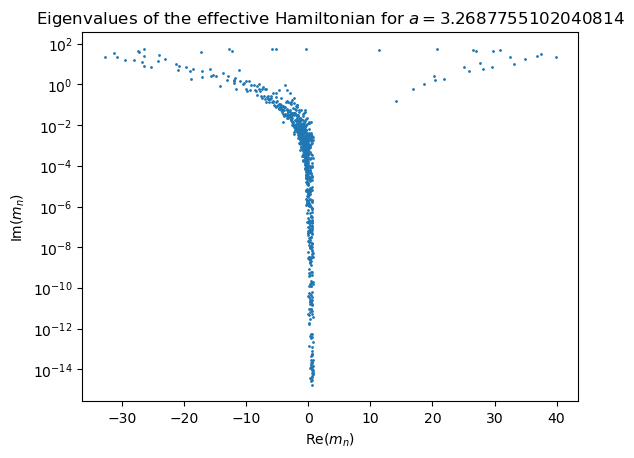

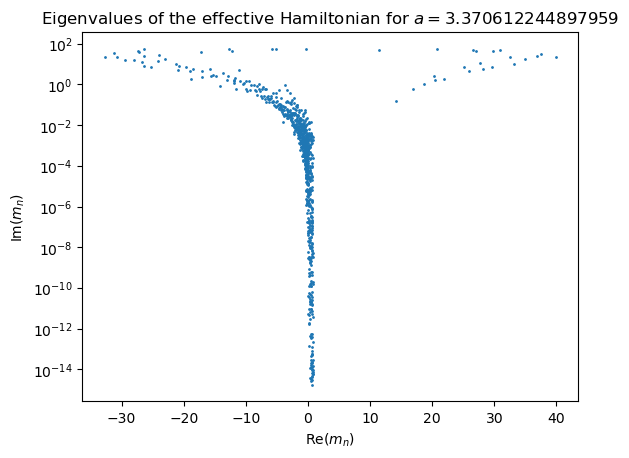

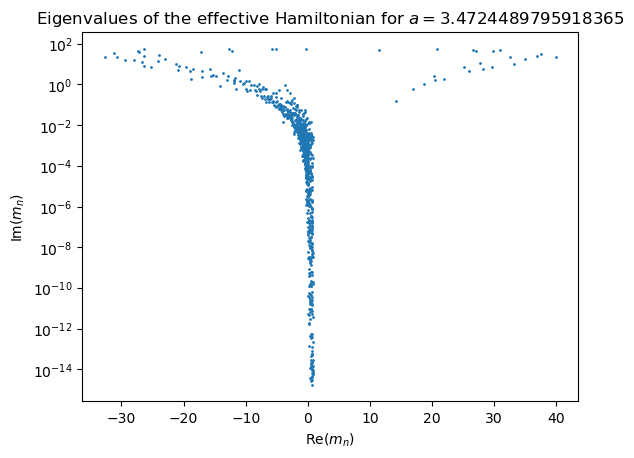

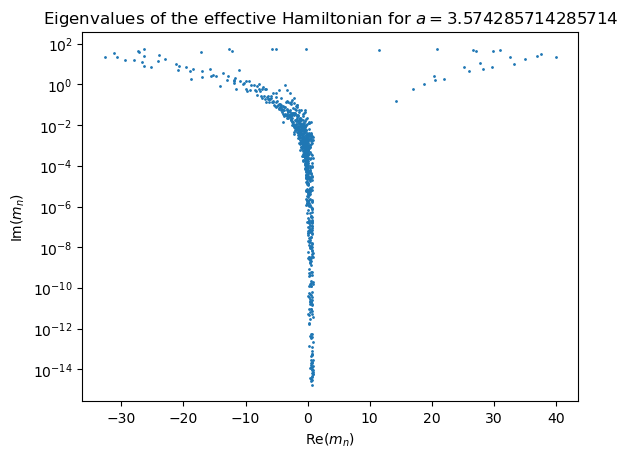

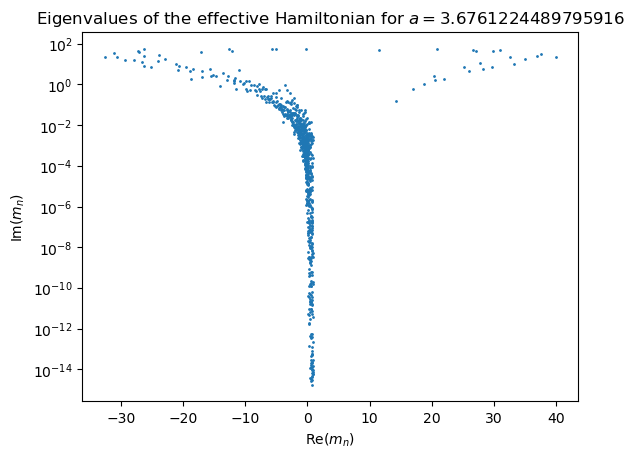

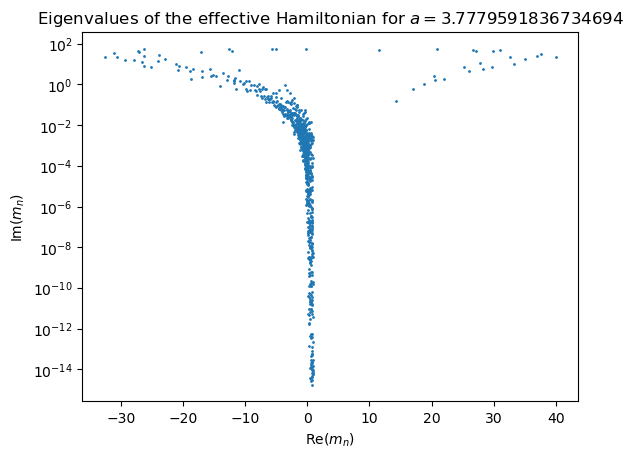

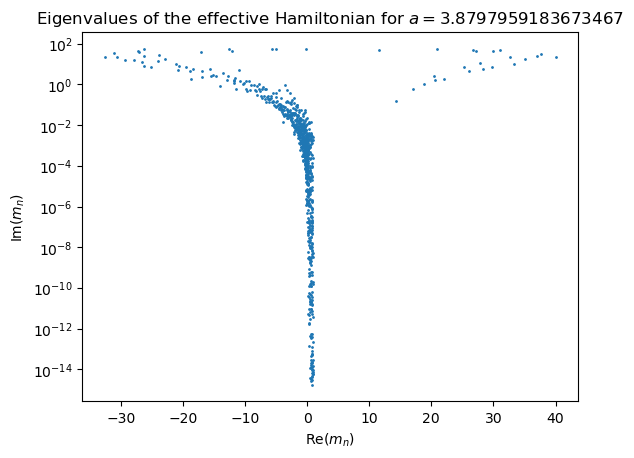

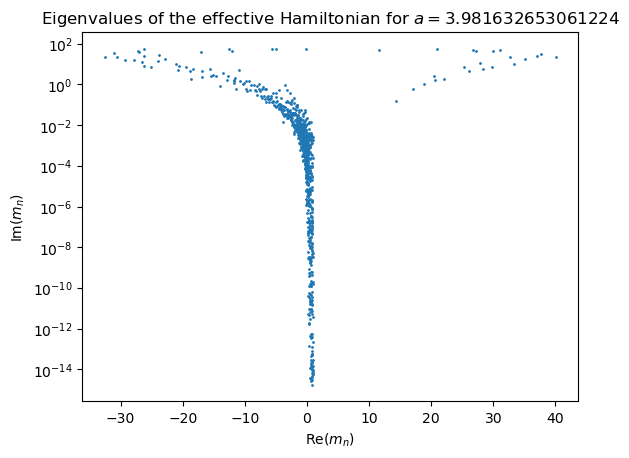

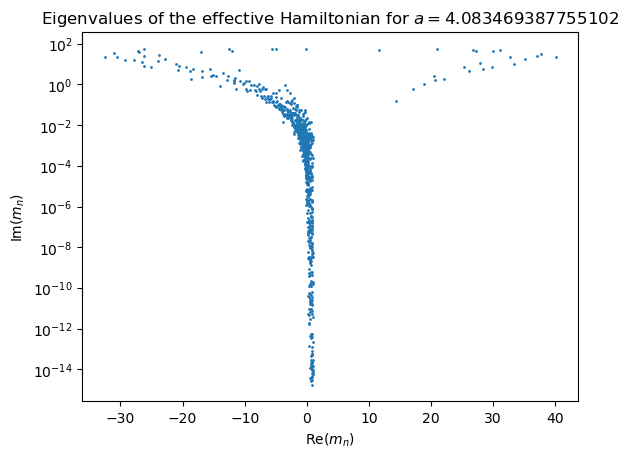

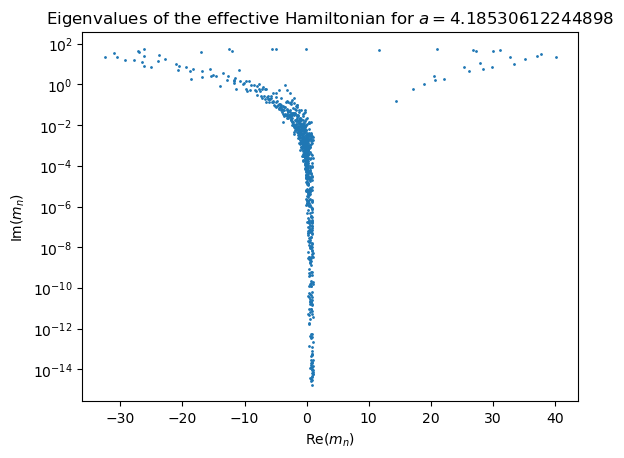

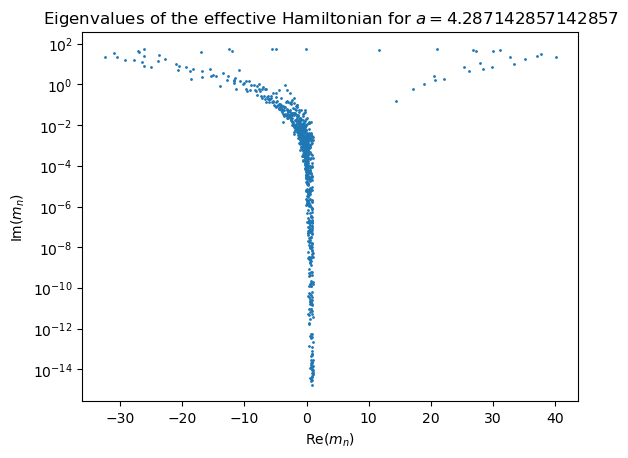

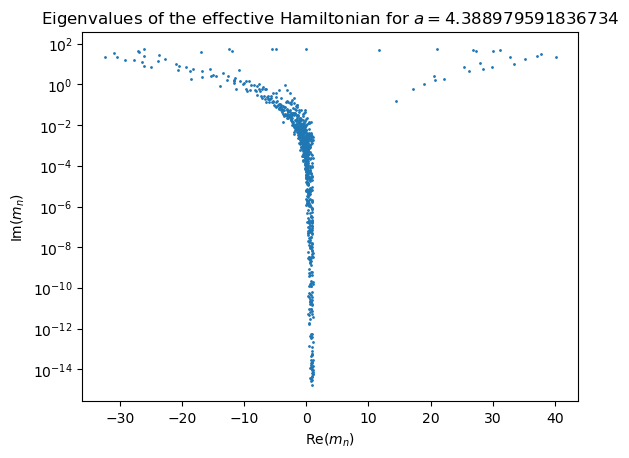

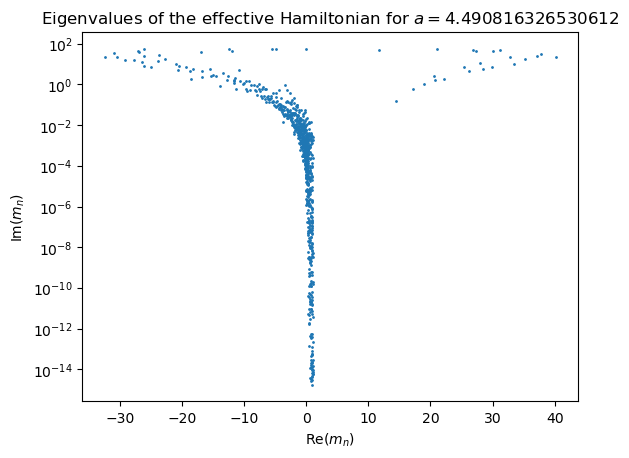

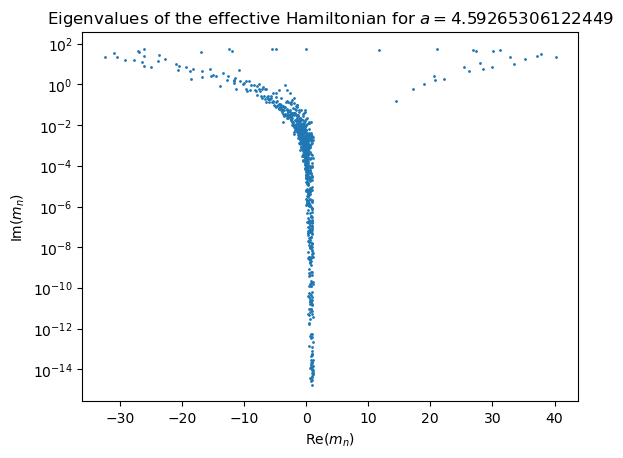

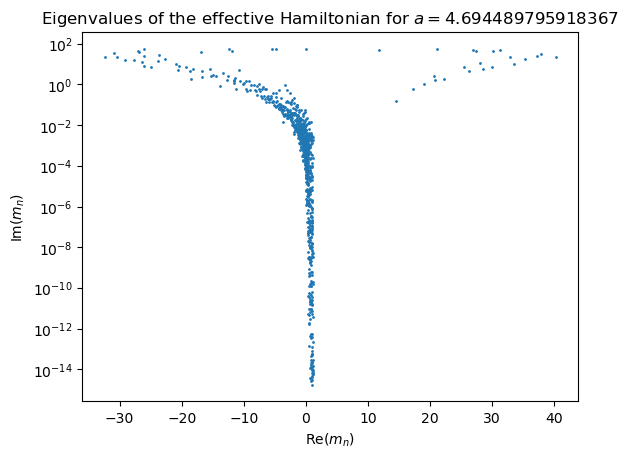

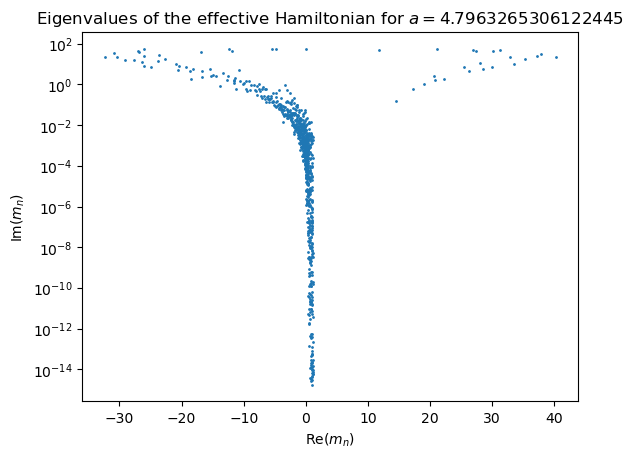

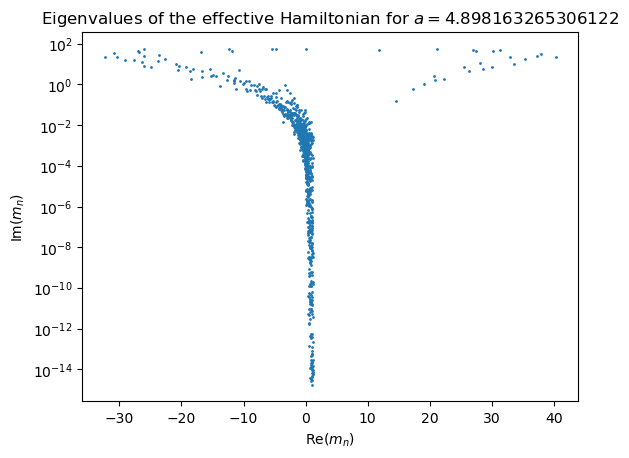

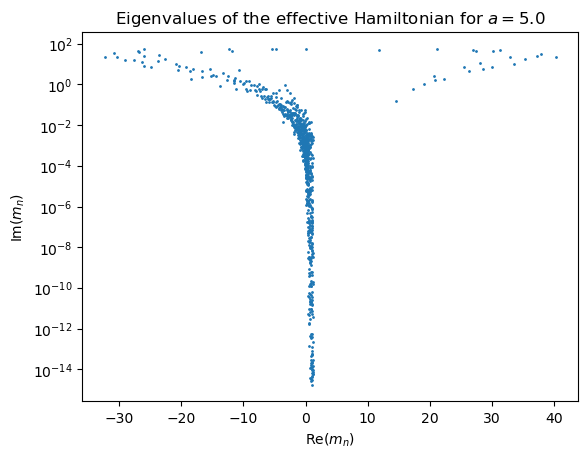

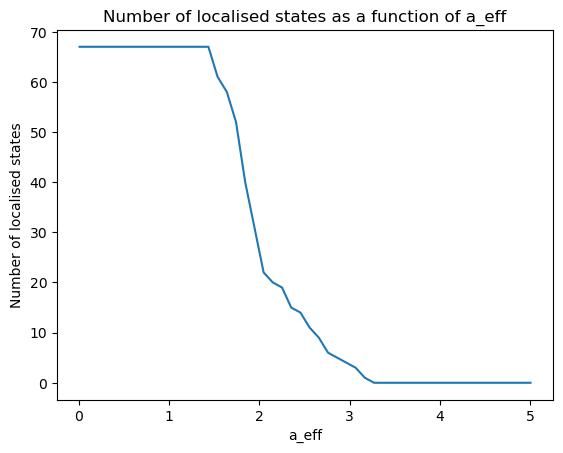

In [93]:
k=0.1
a_eff_vals=np.linspace(0.01, 5, 50)
loc_states_per_k=[]
for a_eff in a_eff_vals:
    num_loc_states=0
    diag,offdiag=generate_diag_off_diag_matrices(k, a_eff, X_dispersors, Y_dispersors)
    m_matrix = diag*np.eye(len(X_dispersors))+offdiag
    off_diag_eigvals, off_diagonal_eigvecs = np.linalg.eig(offdiag)
    eigvals, eigvecs = np.linalg.eig(m_matrix)
    ones = np.ones(shape=off_diagonal_eigvals.shape)
    real_eigvals = (np.log(a_eff*k/2)+gamma_euler-1j*np.pi/2)*ones+off_diag_eigvals
    for q_n in off_diag_eigvals:
        if (np.abs(np.imag(q_n)-np.pi/2)<1e-10) and (np.real(q_n)+gamma_euler+np.log(k*a_eff/2)<1e-10):
            num_loc_states+=1
    loc_states_per_k.append(num_loc_states)
    plt.plot(np.real(real_eigvals), np.abs(np.imag(real_eigvals)), 'o',markersize=1)
    plt.xlabel('Re($m_n$)')
    plt.ylabel('Im($m_n$)')
    plt.title(f'Eigenvalues of the effective Hamiltonian for $a={a_eff}$')
    plt.semilogy()
    plt.show()
plt.plot(a_eff_vals,loc_states_per_k)
plt.xlabel('a_eff')
plt.ylabel('Number of localised states')
plt.title('Number of localised states as a function of a_eff')
plt.show()

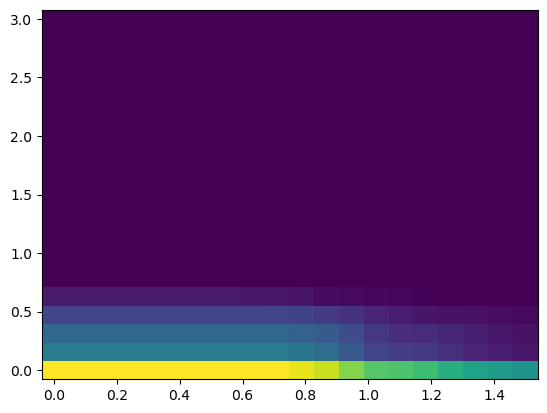

In [98]:
k_val=np.linspace(0.001, 1.5, 20)
a_eff_vals=np.linspace(0.001, 3, 20)
num_loc_states_a_k=np.zeros((len(k_val), len(a_eff_vals)))
for i, k in enumerate(k_val):
    for j, a_eff in enumerate(a_eff_vals):
        num_loc_states=0
        diag,offdiag=generate_diag_off_diag_matrices(k, a_eff, X_dispersors, Y_dispersors)
        m_matrix = diag*np.eye(len(X_dispersors))+offdiag
        off_diag_eigvals, off_diagonal_eigvecs = np.linalg.eig(offdiag)
        eigvals, eigvecs = np.linalg.eig(m_matrix)
        ones = np.ones(shape=off_diagonal_eigvals.shape)
        real_eigvals = (np.log(a_eff*k/2)+gamma_euler-1j*np.pi/2)*ones+off_diag_eigvals
        for q_n in off_diag_eigvals:
            if (np.abs(np.imag(q_n)-np.pi/2)<1e-6) and (np.real(q_n)+gamma_euler+np.log(k*a_eff/2)<1e-6):
                num_loc_states+=1
        num_loc_states_a_k[i,j]=num_loc_states
plt.pcolor(k_val, a_eff_vals, num_loc_states_a_k)

Defining the system of equations as:

$$\mathbf{M}\mathbf{D}=\mathbf{B}$$

Difference in imaginary part of eigenvalues: -1.5707963267948968
 value of i pi/2: 1.5707963267948966
difference in real part of eigenvalues: 0.9237892551815057
 value of ln(k*a_eff*exp(gamma_euler)): 0.9237892551815057


[]

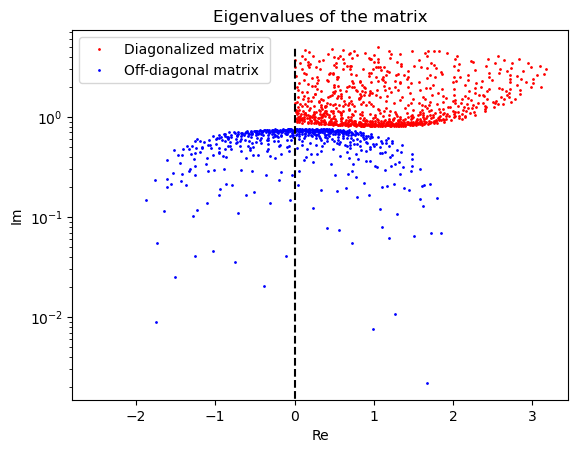

In [53]:
# diagonalize the matrix
eigenvalues, eigenvectors = np.linalg.eig(m_matrix)
# count localized modes
localized_modes = np.sum(np.imag(eigenvalues) < 1e-6)
plt.plot(np.abs(np.real(eigenvalues)), np.abs((np.imag(eigenvalues))), 'ro', markersize=1, label='Diagonalized matrix')

plt.plot(np.real(off_diagonal_eigvals), (np.imag(off_diagonal_eigvals)), 'bo', markersize=1, label='Off-diagonal matrix')
plt.hlines(0, linestyles='dashed', xmin=min(np.real(off_diagonal_eigvals)), xmax=max(np.real(eigenvalues)), colors='k')
plt.vlines(0, linestyles='dashed', ymin=0, ymax=5, colors='k')
imaginary_difference = np.mean(np.imag(eigenvalues) - np.imag(off_diagonal_eigvals))
print(f"Difference in imaginary part of eigenvalues: {imaginary_difference}")
print(f" value of i pi/2: {np.pi/2}")
print(f"difference in real part of eigenvalues: {np.mean(np.real(eigenvalues) - np.real(off_diagonal_eigvals))}")
print(f" value of ln(k*a_eff*exp(gamma_euler)): {np.log(k*a_eff*np.exp(gamma_euler))}")
plt.title('Eigenvalues of the matrix')
plt.xlabel('Re')
plt.ylabel('Im')
plt.legend()
plt.semilogy()

In [ ]:
r0 = np.array([-10, 5])

B_vector = np.zeros(len(X_dispersors), dtype=np.complex128)

for i, (x, y) in enumerate(zip(X_dispersors, Y_dispersors)):
    B_vector[i] = 1j*np.pi/2*hankel1(0, k*np.sqrt((x-r0[0])**2+(y-r0[1])**2))
    
D_vector = np.linalg.solve(m_matrix, B_vector)

Text(0.5, 0, 'Dispersor index $i$')

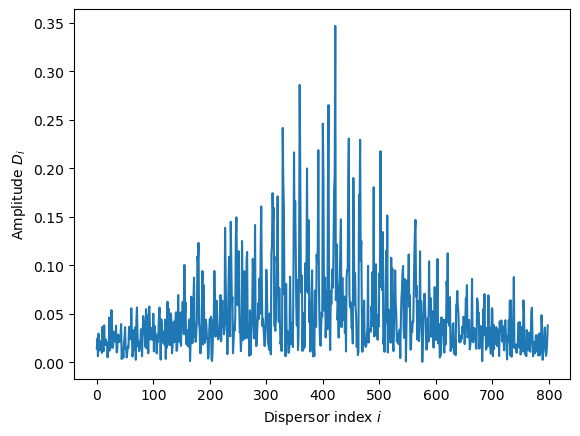

In [ ]:
plt.plot(np.abs(D_vector))
plt.ylabel(r'Amplitude $D_i$')
plt.xlabel(r'Dispersor index $i$')

Text(0.5, 1.0, 'Magnitude of the scattered field')

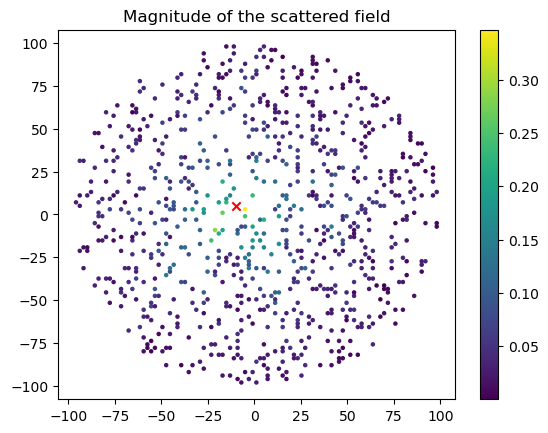

In [ ]:
plt.figure()
plt.scatter(r0[0], r0[1], c='r', label='Source',marker='x')
# plt.scatter(X,Y, c="grey", s=1, label='Lattice points')
plt.scatter(X_dispersors, Y_dispersors, c=np.abs(D_vector), cmap='viridis',s=5)
# for i, (x, y) in enumerate(zip(X_dispersors, Y_dispersors)):
#     plt.text(x, y, f'{i}', fontsize=8)
plt.colorbar()
plt.title('Magnitude of the scattered field')
